In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

In [4]:
df = sns.load_dataset("titanic")
df = df[["age", "fare", "pclass", "sex", "survived"]]
df = df.dropna()
df['sex'] = df['sex'].replace("male", 0)
df['sex'] = df['sex'].replace("female", 1)
np.random.seed(23)
df_train, df_test = np.split(df, [600])

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

decision_tree = DecisionTreeClassifier()
parameters = {'min_impurity_decrease': [0, 0.01, 0.02, 0.05, 0.1]}

cv_model_finder = GridSearchCV(decision_tree, parameters, cv=10)
cv_model_finder.fit(df_train[["age", "fare", "pclass", "sex"]], df_train["survived"])

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'min_impurity_decrease': [0, 0.01, 0.02, 0.05, 0.1]}

Model is 4D so we can't visualize it. However, we can assess its accuracy.

In [6]:
random_forest_predictions = cv_model_finder.best_estimator_.predict(df_train[["age", "fare", "pclass", "sex"]])

In [7]:
from sklearn.metrics import accuracy_score
accuracy_score(df_train["survived"], random_forest_predictions)

0.7916666666666666

In [8]:
from sklearn.metrics import confusion_matrix

In [19]:
cm_rf = confusion_matrix(df_train["survived"], random_forest_predictions)

In [51]:
cm_rf

array([[349,   7],
       [118, 126]])

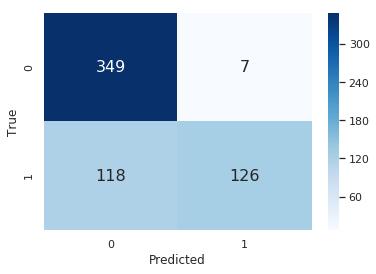

In [53]:
sns.heatmap(cm_rf, annot=True, fmt = "d", cmap = "Blues", annot_kws={"size": 16})
plt.ylabel('True')
plt.xlabel('Predicted');

Above, we see four different values. 

1. Top left: True negatives. Model correctly predicts person died.
2. Top right: False negatives: Model predicts person would survive, but the person died.
3. Bottom left: False positives: Model predicts person would die, but the person survived.
4. Bottom right: True positive: Model correctly predicts the person survived.

The model has a strikingly low number of false negatives.

Let's compare this to a Logistic Regression model.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
logistic_regression_model = Pipeline([        
    ('scale', StandardScaler()),        
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegressionCV(Cs = 10**np.linspace(-7, 5, 100)))
])  
logistic_regression_model.fit(df_train[["fare", "age", "pclass",  "sex"]], df_train["survived"])

### Depcrecated

Two key measures derived from these numbers:

**True positive rate:** 126/(126+118) = 51% [also called the "recall" or "sensitivity" or "probability of detection"]

Out of the 244 who survived in our training set, our model is able to correctly identify 51% of them. Or in other words, for a given person who survived, our model identifies them correctly 51% of the time. Our model's sensitivity is quite poor (about as bad as guessing).

**True negative rate:** 349/(349+7) = 98% [also called the "specificity"]

Out of the 356 who died in our training set, our model is able to correctly identify 98% of them. Or in other words, for a given person who died, our model identifies them correctly 98% of the time.




no almost always right when it predicts that someone would survive, but when #it predicts someone would die, the odds are actually 50/50.

no Our model has very high specificity. If the model predicts you will survive, you can feel pretty confident you actually would. However, if it predicts you will die, you don't get very much information at all.

#### Logistic Regression Model

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

logistic_regression_model_core = Pipeline([        
    ('scale', StandardScaler()),        
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegression())
])  

params = {
    "model__C": 10**np.linspace(-7, 5, 100)
}

gridsearcher = GridSearchCV(estimator = logistic_regression_model_core,
             param_grid = params,
             cv = 10)

gridsearcher.fit(df_train[["fare", "age", "pclass",  "sex"]], df_train["survived"])

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('model',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                              

In [35]:
logistic_regression_predictions_dr = gridsearcher.best_estimator_.predict(df_train[["age", "fare", "pclass", "sex"]])

In [36]:
from sklearn.linear_model import LogisticRegressionCV
logistic_regression_model = Pipeline([        
    ('scale', StandardScaler()),        
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegressionCV(Cs = 10**np.linspace(-7, 5, 100)))
])  
logistic_regression_model.fit(df_train[["fare", "age", "pclass",  "sex"]], df_train["survived"])

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('model',
                 LogisticRegressionCV(Cs=array([1.00000000e-07, 1.32194115e-07, 1.74752840e-07, 2.31012970e-07,
       3.05385551e-07, 4.03701726e-07, 5.33669923e-07, 7.05480231e-07,
       9.326033...
       1.41747416e+04, 1.87381742e+04, 2.47707636e+04, 3.27454916e+04,
       4.32876128e+04, 5.72236766e+04, 7.56463328e+04, 1.00000000e+05]),
                                      class_weight=None, cv=None, dual=False,
                                      fit_intercept=True, intercept_scaling=1.0,
                                      l1_ratios=None, max_iter=100,
                                      multi_class='auto', n_jobs=None,
                                      penal

In [37]:
logistic_regression_predictions = logistic_regression_model.predict(df_train[["age", "fare", "pclass", "sex"]])

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(df_train["survived"], logistic_regression_predictions)

0.7983333333333333

In [39]:
cm_lr = confusion_matrix(df_train["survived"], logistic_regression_predictions)

Text(0.5, 12.5, 'True')

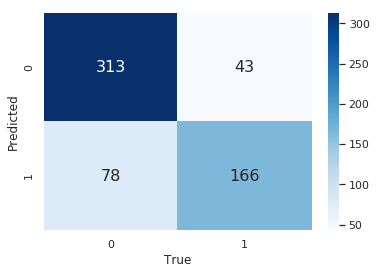

In [40]:
sns.heatmap(cm_lr, annot=True, fmt = "d", cmap = "Blues", annot_kws={"size": 16})
plt.ylabel('Predicted')
plt.xlabel('True')

While the two predictors have similar accuracy, they have quite different confusion matrices.

We can compute specificity (true negative rate) an recall (true positive rate) as:
1. 313/(313+43) = 88% specificity
2. 166/(166+78) = 68% recall

Quick check to see how things work if you do gridsearch (which is better)

Text(0.5, 12.5, 'True')

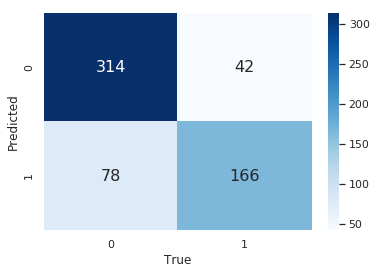

In [42]:
cm_lr_dr = confusion_matrix(df_train["survived"], logistic_regression_predictions_dr)
sns.heatmap(cm_lr_dr, annot=True, fmt = "d", cmap = "Blues", annot_kws={"size": 16})
plt.ylabel('Predicted')
plt.xlabel('True')

Just a quick check to see if doing it right really matters on the test set

Text(0.5, 12.5, 'True')

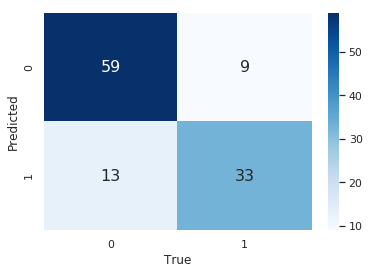

In [47]:
logistic_regression_predictions_dr = gridsearcher.best_estimator_.predict(df_test[["age", "fare", "pclass", "sex"]])
cm_lr_dr = confusion_matrix(df_test["survived"], logistic_regression_predictions_dr)
sns.heatmap(cm_lr_dr, annot=True, fmt = "d", cmap = "Blues", annot_kws={"size": 16})
plt.ylabel('Predicted')
plt.xlabel('True')

Text(0.5, 12.5, 'True')

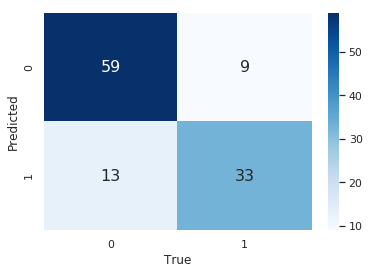

In [48]:
logistic_regression_predictions = logistic_regression_model.predict(df_test[["age", "fare", "pclass", "sex"]])
cm_lr = confusion_matrix(df_test["survived"], logistic_regression_predictions)
sns.heatmap(cm_lr, annot=True, fmt = "d", cmap = "Blues", annot_kws={"size": 16})
plt.ylabel('Predicted')
plt.xlabel('True')

#### Or alternately, a logistic regression model

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [16]:
tiny_c_model_fit_intercept_false = Pipeline([        
    ('scale', StandardScaler()),        
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegression(fit_intercept = False, C = 1e-8))
])   
tiny_c_model_fit_intercept_false.fit(df_train[["fare", "age", "pclass",  "sex"]], 
                                df_train["survived"]);

In [18]:
tiny_c_model_fit_intercept_true = Pipeline([        
    ('scale', StandardScaler()),        
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LogisticRegression(fit_intercept = True, C = 1e-8))
])   
tiny_c_model_fit_intercept_true.fit(df_train[["fare", "age", "pclass",  "sex"]], 
                                df_train["survived"]);

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(df_train["survived"], 
               tiny_c_model_fit_intercept_false.predict(df_train[["age", "fare", "pclass", "sex"]]))

0.6883333333333334

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(df_train["survived"], 
               tiny_c_model_fit_intercept_true.predict(df_train[["age", "fare", "pclass", "sex"]]))

0.5933333333333334

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'min_impurity_decrease': [0, 0.01, 0.02, 0.05, 0.1]}
mindwg_decision_tree = tree.DecisionTreeClassifier()
cv_model_finder = GridSearchCV(mindwg_decision_tree, parameters, cv=10)
cv_model_finder.fit(train_iris_data[["sepal_length", "sepal_width"]], train_iris_data["species"])

In [ ]:
p1a_df = df[["survived", "age"]].copy()
p1a_df = p1a_df.dropna() # drop entries with missing data
p1a_df = p1a_df.sort_values("age") # sort data by age, which will make it easier to plot the data nicely

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(training_reality, training_predictions)

In [ ]:
sns.heatmap(cm, annot=True, fmt = "d", cmap = "Blues", annot_kws={"size": 16})
plt.ylabel('Predicted')
plt.xlabel('True')

In [ ]:
cm_test = confusion_matrix(test_reality, test_predictions)

In [ ]:
sns.heatmap(cm_test, annot=True, fmt = "d", cmap = "Blues", annot_kws={"size": 16})
plt.ylabel('Predicted')
plt.xlabel('True')

In [ ]:
cm_test = confusion_matrix(test_reality, test_predictions)

In [ ]:
# precision recall

In [ ]:
training_predictions = p3c_model.predict_proba(p3_train[["fare", "age", "pclass",  "sex"]])[:, 1]

In [ ]:
def compute_TPR_FPR(y_obs, y_hat):
    TP = sum((y_obs == y_hat) & (y_obs == 1))
    FN = sum((y_obs != y_hat) & (y_obs == 1))
    TPR = TP / (TP + FN)
    
    TN = sum((y_obs == y_hat) & (y_obs == 0))
    FP = sum((y_obs != y_hat) & (y_obs == 0))
    FPR = FP / (FP + TN)
       
    return TPR, FPR

In [ ]:
def compute_model_TPR_FPR(ps, y_obs, threshold):    
    y_hat = ps > threshold    
    return compute_TPR_FPR(y_obs, y_hat)

In [ ]:
compute_model_TPR_FPR(training_predictions, p3_train["survived"], 0.5)

In [ ]:
def print_model_TPR_FPR(ps, y_obs, threshold):
    TPR, FPR = compute_model_TPR_FPR(ps, y_obs, threshold)
    print(f'TPR: {TPR * 100:.1f}%, FPR: {FPR * 100:.1f}%')

In [ ]:
print_model_TPR_FPR(training_predictions, p3_train["survived"], 0.5)

In [ ]:
thresholds = np.linspace(0, 1, 101)
TPRs_best_model = []
FPRs_best_model = []
for threshold in thresholds:
    TPR, FPR = compute_model_TPR_FPR(training_predictions, p3_train["survived"], threshold)
    TPRs_best_model.append(TPR)
    FPRs_best_model.append(FPR)

plt.plot(FPRs_best_model, TPRs_best_model)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data');

In [ ]:
test_predictions = p3c_model.predict_proba(p3_test[["fare", "age", "pclass",  "sex"]])[:, 1]

In [ ]:
thresholds = np.linspace(0, 1, 101)
TPRs_best_model = []
FPRs_best_model = []
for threshold in thresholds:
    TPR, FPR = compute_model_TPR_FPR(test_predictions, p3_test["survived"], threshold)
    TPRs_best_model.append(TPR)
    FPRs_best_model.append(FPR)

plt.plot(FPRs_best_model, TPRs_best_model)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data');